<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); color: white; padding: 40px; margin: -10px -10px 20px -10px; border-radius: 0 0 15px 15px;">
<h1 style="margin: 0; font-size: 2.5em;">Layout & Fabrication</h1>
<p style="margin: 10px 0 0 0; font-size: 1.2em; opacity: 0.9;">Week 2, Session 2 — Fab Futures</p>
</div>

## Contents

- [How Chips Are Made](#how-chips-are-made) — *30-second primer*

1. [What is Layout?](#1-what-is-layout)
2. [Design Rules](#2-design-rules)
3. [DRC: Design Rule Check](#3-drc-design-rule-check)
4. [LVS: Layout vs Schematic](#4-lvs-layout-vs-schematic)
5. [The Fabrication Process](#5-the-fabrication-process)
6. [From GDS to Silicon](#6-from-gds-to-silicon)

---
<a id="how-chips-are-made"></a>
## How Chips Are Made (30-Second Version)

Before diving into layout rules, here's the basic idea of chip fabrication:

### The Core Process

Chips are built by repeating three steps for each layer:

```
1. DEPOSIT    →    2. PATTERN    →    3. ETCH
   (add material)      (use light)       (remove unwanted)
```

### Photolithography: Printing with Light

**Photolithography** is how we define tiny features:

1. Coat the wafer with **photoresist** (light-sensitive material)
2. Shine UV light through a **mask** (like a stencil)
3. **Develop** — exposed areas wash away (or stay, depending on resist type)
4. **Etch** — remove material where resist was removed
5. **Strip** the remaining resist

Think of it like screen printing, but with light and at nanometer scale.

### CMP: Making It Flat

After adding layers, the surface gets bumpy. **CMP (Chemical Mechanical Planarization)** polishes it flat:

- Wafer pressed against rotating pad with slurry
- Combination of chemical reaction + mechanical grinding
- Critical for stacking many metal layers

**Why CMP matters for design rules:**
- Too much metal in one area → **erosion** (over-polishing)
- Too little metal → **dishing** (under-polishing in gaps)
- This is why we have **metal density rules**

---

In [1]:
# Setup
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle, FancyArrowPatch
from matplotlib.collections import PatchCollection
import numpy as np

# Layer colors for visualizations
M1_COLOR = '#2196F3'   # Metal 1 - blue
M2_COLOR = '#FF9800'   # Metal 2 - orange
VIA_COLOR = '#9C27B0'  # Via - purple

print("Setup complete.")

Setup complete.


---
<a id="1-the-layout-process"></a>
# 1. The Layout Process
---

There are several different layout **flows** depending on your design type:

### Layout Only / Layout First
- Typically used by the fab for **process characterization features**
- Metal and oxide thickness, mask alignment, critical dimension checks

### Analog Flow
- **Schematic first**, SPICE simulation driven designs
- Uses schematic-driven placement to match layout components to schematic components

### Digital / RTL-to-GDS Flow
- May *skip* a schematic & SPICE representation
- Goes straight from **hardware description language** and logic simulation (e.g., multipliers or NAND gates) to GDS
- Substantially automated layout generation and checking

### Cell Hierarchy

Layouts are organized hierarchically — smaller cells are instantiated inside larger cells:

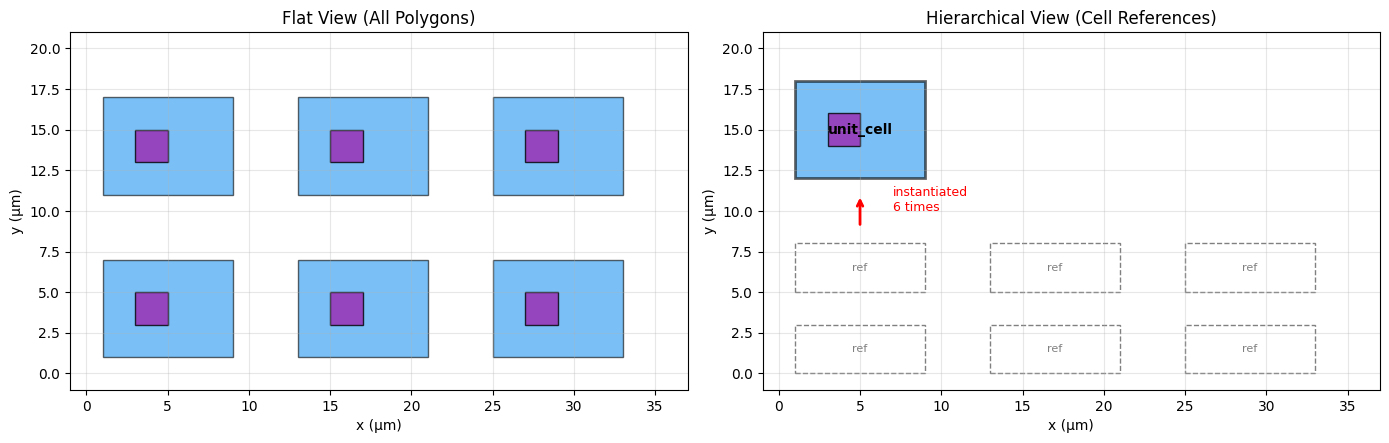

Hierarchy reduces file size: instead of storing 6 copies of geometry,
we store 1 cell definition + 6 references (position, rotation, scale).


In [2]:
# Visualizing cell hierarchy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Flat view (all polygons)
ax1.set_title("Flat View (All Polygons)", fontsize=12)
# Draw a 3x2 array of identical "cells"
for i in range(3):
    for j in range(2):
        x_off, y_off = i * 12, j * 10
        # Each "cell" has same geometry
        ax1.add_patch(patches.Rectangle((x_off + 1, y_off + 1), 8, 6, 
                      facecolor=M1_COLOR, alpha=0.6, edgecolor='black'))
        ax1.add_patch(patches.Rectangle((x_off + 3, y_off + 3), 2, 2, 
                      facecolor=VIA_COLOR, alpha=0.8, edgecolor='black'))
ax1.set_xlim(-1, 37)
ax1.set_ylim(-1, 21)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('x (µm)')
ax1.set_ylabel('y (µm)')

# Right: Hierarchical view
ax2.set_title("Hierarchical View (Cell References)", fontsize=12)
# Draw the base cell once
ax2.add_patch(patches.Rectangle((1, 12), 8, 6, 
              facecolor=M1_COLOR, alpha=0.6, edgecolor='black', linewidth=2))
ax2.add_patch(patches.Rectangle((3, 14), 2, 2, 
              facecolor=VIA_COLOR, alpha=0.8, edgecolor='black'))
ax2.text(5, 15, 'unit_cell', ha='center', va='center', fontsize=10, fontweight='bold')

# Show it's referenced multiple times
for i in range(3):
    for j in range(2):
        x_off, y_off = i * 12 + 1, j * 5
        ax2.add_patch(patches.Rectangle((x_off, y_off), 8, 3, 
                      facecolor='none', edgecolor='gray', linestyle='--', linewidth=1))
        ax2.text(x_off + 4, y_off + 1.5, f'ref', ha='center', va='center', 
                fontsize=8, color='gray')

# Arrow showing relationship
ax2.annotate('', xy=(5, 11), xytext=(5, 9),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax2.text(7, 10, 'instantiated\n6 times', fontsize=9, color='red')

ax2.set_xlim(-1, 37)
ax2.set_ylim(-1, 21)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('x (µm)')
ax2.set_ylabel('y (µm)')

plt.tight_layout()
plt.show()

print("Hierarchy reduces file size: instead of storing 6 copies of geometry,")
print("we store 1 cell definition + 6 references (position, rotation, scale).")

---
<a id="2-design-verification"></a>
# 2. Design Verification
---

## Design Rule Checking (DRC)

DRC ensures your layout meets the **physical constraints** of the fabrication process. These rules exist because of lithography resolution limits, etching characteristics, and reliability requirements.

**Note:** The examples below use simplified values for illustration. Real PDK rules are much more detailed. For reference, here are some actual **SkyWater 130nm** rules:

| Rule | Illustrative | Actual Sky130 |
|------|-------------|---------------|
| M1 min width | 1.0 um | 0.14 um |
| M1 min space | 1.5 um | 0.14 um |
| Via enclosure | 0.5 um | 0.03-0.06 um |
| Metal density | 20-80% | varies by layer |

**Density rules note:** Sky130 density requirements differ by metal layer and process variant (aluminum vs copper). For example, M1 copper has a maximum density of 77% while other layers differ. Always consult the actual PDK documentation: [skywater-pdk.readthedocs.io](https://skywater-pdk.readthedocs.io/en/main/rules.html)

### Minimum Width

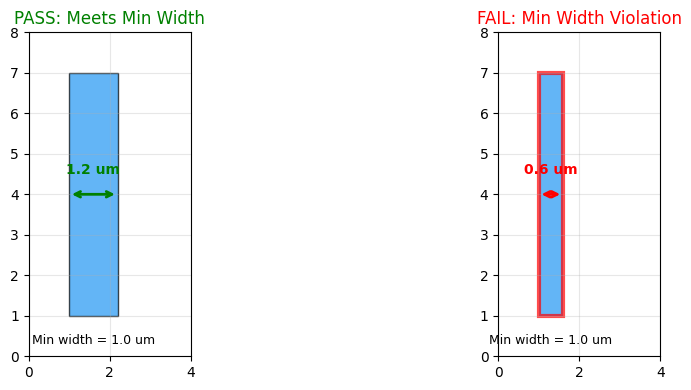

In [3]:
# DRC: Minimum Width
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

min_width = 1.0  # Minimum width rule: 1µm

# Good: meets minimum width
ax1.add_patch(patches.Rectangle((1, 1), 1.2, 6, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax1.annotate('', xy=(1, 4), xytext=(2.2, 4), arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax1.text(1.6, 4.5, '1.2 um', ha='center', fontsize=10, color='green', fontweight='bold')
ax1.text(1.6, 0.3, f'Min width = {min_width} um', ha='center', fontsize=9)
ax1.set_title('PASS: Meets Min Width', fontsize=12, color='green')
ax1.set_xlim(0, 4)
ax1.set_ylim(0, 8)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Bad: violates minimum width  
ax2.add_patch(patches.Rectangle((1, 1), 0.6, 6, facecolor=M1_COLOR, alpha=0.7, edgecolor='red', linewidth=3))
ax2.annotate('', xy=(1, 4), xytext=(1.6, 4), arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax2.text(1.3, 4.5, '0.6 um', ha='center', fontsize=10, color='red', fontweight='bold')
ax2.text(1.3, 0.3, f'Min width = {min_width} um', ha='center', fontsize=9)
ax2.set_title('FAIL: Min Width Violation', fontsize=12, color='red')
ax2.set_xlim(0, 4)
ax2.set_ylim(0, 8)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Minimum Spacing

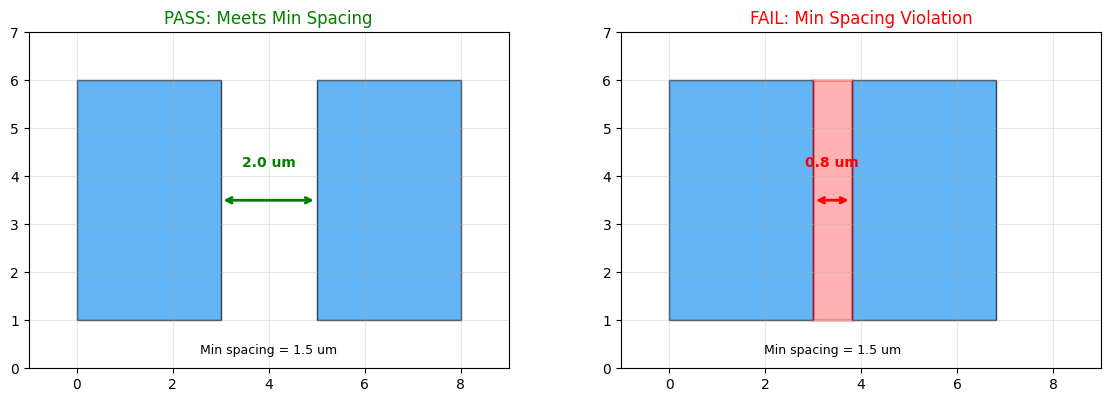

In [4]:
# DRC: Minimum Spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

min_space = 1.5  # Minimum spacing rule: 1.5µm

# Good: adequate spacing
ax1.add_patch(patches.Rectangle((0, 1), 3, 5, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax1.add_patch(patches.Rectangle((5, 1), 3, 5, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax1.annotate('', xy=(3, 3.5), xytext=(5, 3.5), arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax1.text(4, 4.2, '2.0 um', ha='center', fontsize=10, color='green', fontweight='bold')
ax1.text(4, 0.3, f'Min spacing = {min_space} um', ha='center', fontsize=9)
ax1.set_title('PASS: Meets Min Spacing', fontsize=12, color='green')
ax1.set_xlim(-1, 9)
ax1.set_ylim(0, 7)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Bad: spacing violation
ax2.add_patch(patches.Rectangle((0, 1), 3, 5, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax2.add_patch(patches.Rectangle((3.8, 1), 3, 5, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
# Highlight the violation area
ax2.add_patch(patches.Rectangle((3, 1), 0.8, 5, facecolor='red', alpha=0.3, edgecolor='red', linewidth=2))
ax2.annotate('', xy=(3, 3.5), xytext=(3.8, 3.5), arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax2.text(3.4, 4.2, '0.8 um', ha='center', fontsize=10, color='red', fontweight='bold')
ax2.text(3.4, 0.3, f'Min spacing = {min_space} um', ha='center', fontsize=9)
ax2.set_title('FAIL: Min Spacing Violation', fontsize=12, color='red')
ax2.set_xlim(-1, 9)
ax2.set_ylim(0, 7)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Enclosure Rules (Via must be enclosed by metal)

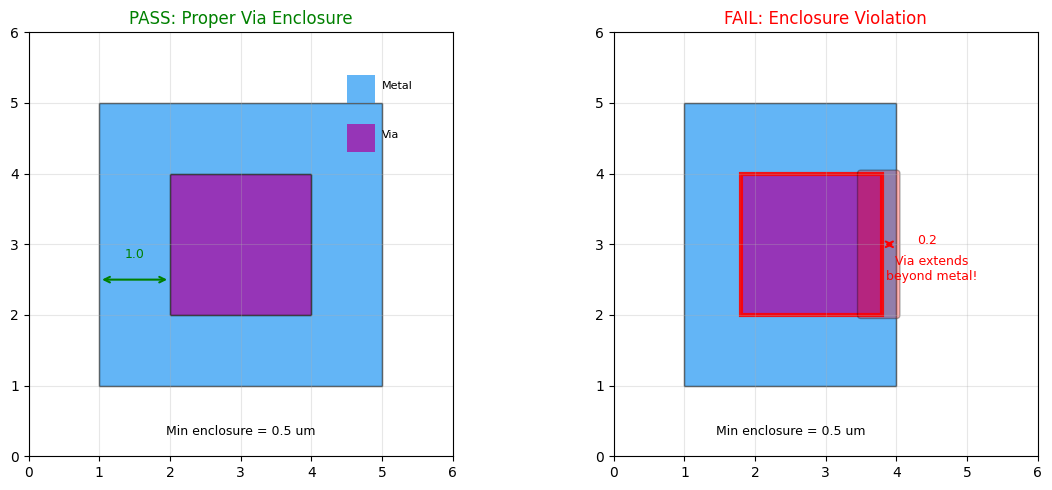

In [5]:
# DRC: Enclosure Rules
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

min_enclosure = 0.5  # Via must be enclosed by 0.5µm of metal on all sides

# Good: proper enclosure
ax1.add_patch(patches.Rectangle((1, 1), 4, 4, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax1.add_patch(patches.Rectangle((2, 2), 2, 2, facecolor=VIA_COLOR, alpha=0.9, edgecolor='black'))
# Show enclosure dimension
ax1.annotate('', xy=(1, 2.5), xytext=(2, 2.5), arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))
ax1.text(1.5, 2.8, '1.0', ha='center', fontsize=9, color='green')
ax1.text(3, 0.3, f'Min enclosure = {min_enclosure} um', ha='center', fontsize=9)
ax1.set_title('PASS: Proper Via Enclosure', fontsize=12, color='green')
ax1.set_xlim(0, 6)
ax1.set_ylim(0, 6)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
# Legend
ax1.add_patch(patches.Rectangle((4.5, 5), 0.4, 0.4, facecolor=M1_COLOR, alpha=0.7))
ax1.text(5, 5.2, 'Metal', fontsize=8)
ax1.add_patch(patches.Rectangle((4.5, 4.3), 0.4, 0.4, facecolor=VIA_COLOR, alpha=0.9))
ax1.text(5, 4.5, 'Via', fontsize=8)

# Bad: enclosure violation
ax2.add_patch(patches.Rectangle((1, 1), 3, 4, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax2.add_patch(patches.Rectangle((1.8, 2), 2, 2, facecolor=VIA_COLOR, alpha=0.9, edgecolor='red', linewidth=3))
# Highlight the problem area
ax2.add_patch(patches.FancyBboxPatch((3.5, 2), 0.5, 2, facecolor='red', alpha=0.3,
              boxstyle='round,pad=0.05'))
ax2.annotate('', xy=(3.8, 3), xytext=(4, 3), arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax2.text(4.3, 3, '0.2', ha='left', fontsize=9, color='red')
ax2.text(2.5, 0.3, f'Min enclosure = {min_enclosure} um', ha='center', fontsize=9)
ax2.text(4.5, 2.5, 'Via extends\nbeyond metal!', fontsize=9, color='red', ha='center')
ax2.set_title('FAIL: Enclosure Violation', fontsize=12, color='red')
ax2.set_xlim(0, 6)
ax2.set_ylim(0, 6)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Metal Density Rules

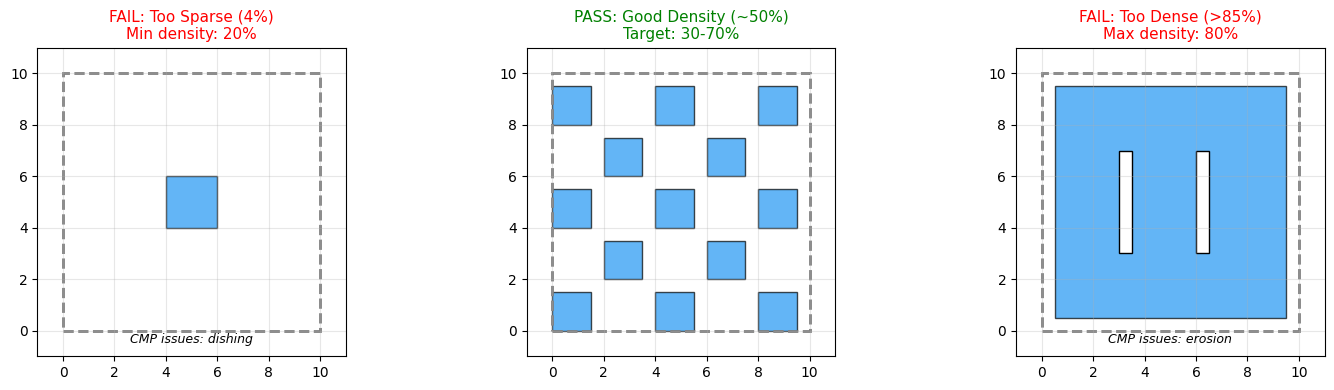

Density rules ensure uniform polishing during CMP (Chemical Mechanical Planarization).
Fill patterns are often auto-generated to meet density requirements.


In [6]:
# DRC: Metal Density
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Window for density check
window_size = 10

def add_density_window(ax):
    ax.add_patch(patches.Rectangle((0, 0), window_size, window_size, 
                 facecolor='none', edgecolor='gray', linestyle='--', linewidth=2))
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Too sparse (< 20%)
ax1.add_patch(patches.Rectangle((4, 4), 2, 2, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
add_density_window(ax1)
ax1.set_title('FAIL: Too Sparse (4%)\nMin density: 20%', fontsize=11, color='red')
ax1.text(5, -0.5, 'CMP issues: dishing', ha='center', fontsize=9, style='italic')

# Good density (40-60%)
for i in range(5):
    for j in range(5):
        if (i + j) % 2 == 0:
            ax2.add_patch(patches.Rectangle((i*2, j*2), 1.5, 1.5, 
                          facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
add_density_window(ax2)
ax2.set_title('PASS: Good Density (~50%)\nTarget: 30-70%', fontsize=11, color='green')

# Too dense (> 80%)
ax3.add_patch(patches.Rectangle((0.5, 0.5), 9, 9, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
# Small gaps
ax3.add_patch(patches.Rectangle((3, 3), 0.5, 4, facecolor='white', edgecolor='black'))
ax3.add_patch(patches.Rectangle((6, 3), 0.5, 4, facecolor='white', edgecolor='black'))
add_density_window(ax3)
ax3.set_title('FAIL: Too Dense (>85%)\nMax density: 80%', fontsize=11, color='red')
ax3.text(5, -0.5, 'CMP issues: erosion', ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

print("Density rules ensure uniform polishing during CMP (Chemical Mechanical Planarization).")
print("Fill patterns are often auto-generated to meet density requirements.")

### Other Reliability Rules

Beyond basic geometry checks, DRC includes reliability rules:

**Antenna Rules**
- During plasma etching, long metal wires can accumulate charge
- This charge can damage thin gate oxides connected to the wire
- **Fix**: Add protective diodes or break long routes with vias to upper metals
- Tools often auto-fix these; you'll see "antenna diodes" in your layout

**Electromigration**
- High current density causes metal atoms to migrate over time
- Eventually creates voids (opens) or hillocks (shorts)
- **Rule**: Minimum wire width depends on expected current
- Power/ground routes need to be wider than signal routes

These rules matter more for production chips than educational tapeouts, but the DRC deck will flag them regardless.

## Layout vs. Schematic Checking (LVS)

LVS verifies that your **physical layout** matches your **logical schematic**:
- Extracts a netlist from the layout geometry
- Compares against the original schematic netlist
- Reports mismatches: shorts, opens, missing components, parameter differences

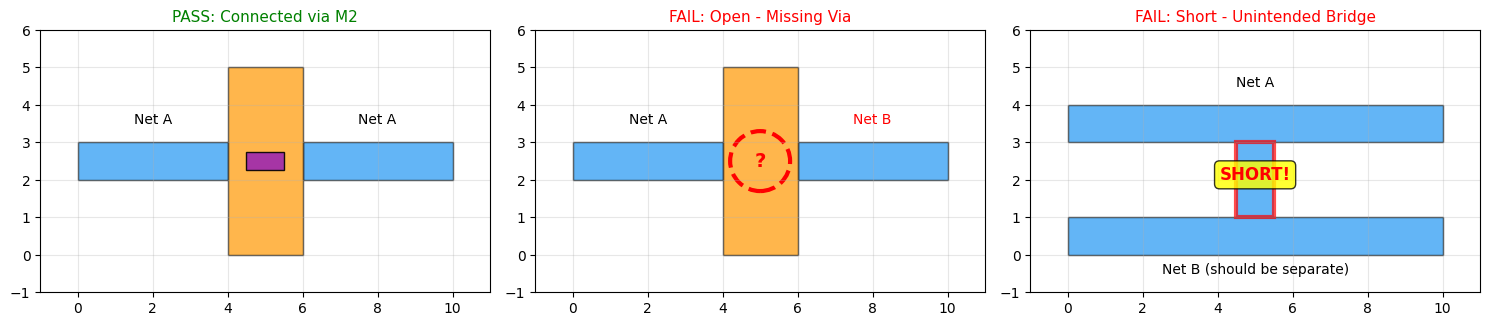

In [7]:
# LVS: Common errors
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Correct connectivity
ax = axes[0]
ax.add_patch(patches.Rectangle((0, 2), 4, 1, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax.add_patch(patches.Rectangle((6, 2), 4, 1, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax.add_patch(patches.Rectangle((4, 0), 2, 5, facecolor=M2_COLOR, alpha=0.7, edgecolor='black'))
ax.add_patch(patches.Rectangle((4.5, 2.25), 1, 0.5, facecolor=VIA_COLOR, alpha=0.9, edgecolor='black'))
ax.text(2, 3.5, 'Net A', ha='center', fontsize=10)
ax.text(8, 3.5, 'Net A', ha='center', fontsize=10)
ax.set_title('PASS: Connected via M2', fontsize=11, color='green')
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Open circuit (missing via)
ax = axes[1]
ax.add_patch(patches.Rectangle((0, 2), 4, 1, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax.add_patch(patches.Rectangle((6, 2), 4, 1, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax.add_patch(patches.Rectangle((4, 0), 2, 5, facecolor=M2_COLOR, alpha=0.7, edgecolor='black'))
# Missing via!
ax.add_patch(patches.Circle((5, 2.5), 0.8, facecolor='none', edgecolor='red', linewidth=3, linestyle='--'))
ax.text(5, 2.5, '?', ha='center', va='center', fontsize=14, color='red', fontweight='bold')
ax.text(2, 3.5, 'Net A', ha='center', fontsize=10)
ax.text(8, 3.5, 'Net B', ha='center', fontsize=10, color='red')
ax.set_title('FAIL: Open - Missing Via', fontsize=11, color='red')
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Short circuit (unintended connection)
ax = axes[2]
ax.add_patch(patches.Rectangle((0, 3), 10, 1, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
ax.add_patch(patches.Rectangle((0, 0), 10, 1, facecolor=M1_COLOR, alpha=0.7, edgecolor='black'))
# Unintended bridge
ax.add_patch(patches.Rectangle((4.5, 1), 1, 2, facecolor=M1_COLOR, alpha=0.7, edgecolor='red', linewidth=3))
ax.text(5, 4.5, 'Net A', ha='center', fontsize=10)
ax.text(5, -0.5, 'Net B (should be separate)', ha='center', fontsize=10)
ax.annotate('SHORT!', xy=(5, 2), fontsize=12, color='red', fontweight='bold',
           ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
ax.set_title('FAIL: Short - Unintended Bridge', fontsize=11, color='red')
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
<a id="3-process-development-kits"></a>
# 3. Process Development Kits
---

A **PDK** (Process Development Kit) provides everything you need to design for a specific fab process:

| Component | Purpose |
|-----------|----------|
| **Layer Maps** | Defines which GDS layers correspond to which physical layers |
| **Feature Sizes** | Minimum/maximum dimensions for each layer |
| **Design Rules** | DRC rule deck for the process |
| **Device Models** | SPICE models for transistors, resistors, capacitors |
| **Standard Cells** | Pre-designed logic gates (for digital flows) |

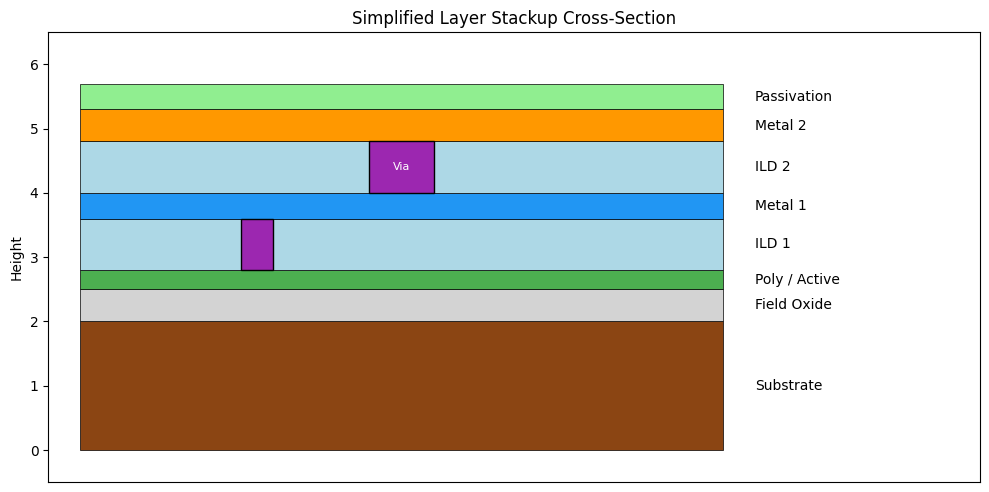

In [8]:
# Example: Layer stackup visualization
fig, ax = plt.subplots(figsize=(10, 6))

layers = [
    ('Substrate', '#8B4513', 0, 2),
    ('Field Oxide', '#D3D3D3', 2, 0.5),
    ('Poly / Active', '#4CAF50', 2.5, 0.3),
    ('ILD 1', '#ADD8E6', 2.8, 0.8),
    ('Metal 1', '#2196F3', 3.6, 0.4),
    ('ILD 2', '#ADD8E6', 4.0, 0.8),
    ('Metal 2', '#FF9800', 4.8, 0.5),
    ('Passivation', '#90EE90', 5.3, 0.4),
]

for name, color, y, height in layers:
    ax.add_patch(patches.Rectangle((0, y), 10, height, 
                 facecolor=color, edgecolor='black', linewidth=0.5))
    ax.text(10.5, y + height/2, name, va='center', fontsize=10)

# Add via between M1 and M2
ax.add_patch(patches.Rectangle((4.5, 4.0), 1, 0.8, facecolor='#9C27B0', edgecolor='black'))
ax.text(5, 4.4, 'Via', ha='center', va='center', fontsize=8, color='white')

# Add contact to poly
ax.add_patch(patches.Rectangle((2.5, 2.8), 0.5, 0.8, facecolor='#9C27B0', edgecolor='black'))

ax.set_xlim(-0.5, 14)
ax.set_ylim(-0.5, 6.5)
ax.set_aspect('equal')
ax.set_title('Simplified Layer Stackup Cross-Section', fontsize=12)
ax.set_ylabel('Height')
ax.set_xticks([])

plt.tight_layout()
plt.show()

### Multiple Metal Layers

Modern chips have **multiple metal layers** stacked on top of each other:

| Layer | Typical Use | Characteristics |
|-------|-------------|-----------------|
| **M1** (lowest) | Local connections | Thinnest, highest resistance |
| **M2-M4** | Intermediate routing | Medium thickness |
| **Top metals** | Power, clock, long routes | Thickest, lowest resistance |

**Why multiple layers?**
- Wires can **cross over** each other on different layers
- **Vias** connect between layers
- More routing resources = denser designs
- Upper layers have lower resistance for long-distance signals

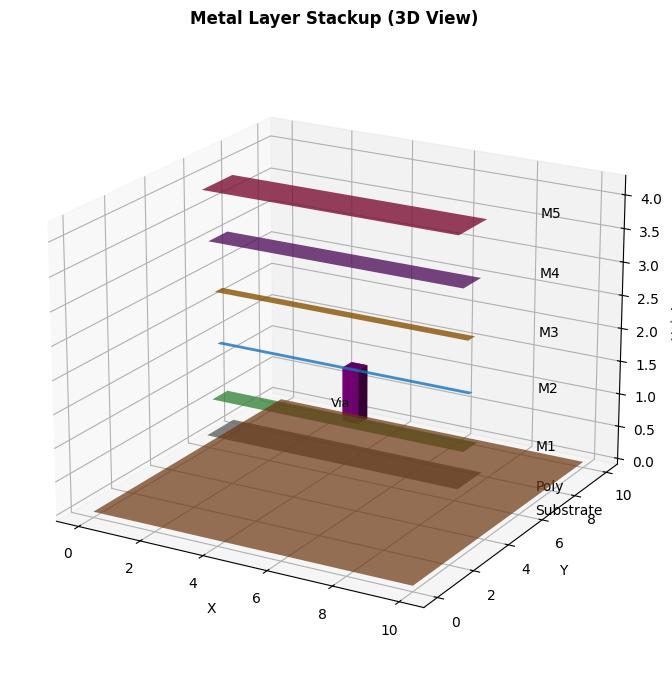

Lower metals (M1-M2): Thin, high resistance — used for local connections
Upper metals (M4-M5): Thick, low resistance — used for power and clock distribution


In [9]:
# 3D visualization of metal layer stackup
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')

# Colors for each layer
colors = ['#8B4513', '#808080', '#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#E91E63']
labels = ['Substrate', 'Poly', 'M1', 'M2', 'M3', 'M4', 'M5']
heights = [0, 0.5, 1.0, 1.8, 2.6, 3.4, 4.2]
thicknesses = [0.4, 0.1, 0.3, 0.4, 0.4, 0.5, 0.6]

for i, (color, label, z, thick) in enumerate(zip(colors, labels, heights, thicknesses)):
    # Draw each layer as a semi-transparent surface
    if i == 0:  # Substrate - full
        xx, yy = np.meshgrid([0, 10], [0, 10])
        ax.plot_surface(xx, yy, np.ones_like(xx) * z, alpha=0.7, color=color)
    else:  # Metal layers - partial stripes for visibility
        # Horizontal stripe
        xx, yy = np.meshgrid([1, 9], [4 + i*0.3, 6 - i*0.3])
        ax.plot_surface(xx, yy, np.ones_like(xx) * z, alpha=0.8, color=color)

    ax.text(11, 5, z + thick/2, label, fontsize=10)

# Add via between M1 and M2
ax.bar3d(5, 5, 1.0, 0.5, 0.5, 0.8, color='purple', alpha=0.9)
ax.text(5.2, 4, 1.4, 'Via', fontsize=9)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
ax.set_title('Metal Layer Stackup (3D View)', fontsize=12, fontweight='bold')
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
plt.show()

print("Lower metals (M1-M2): Thin, high resistance — used for local connections")
print("Upper metals (M4-M5): Thick, low resistance — used for power and clock distribution")

---
<a id="4-layout-tools--file-formats"></a>
# 4. Layout Tools & File Formats
---

### Open Source Tools
- **KLayout** — GUI-based viewer and editor
- **gdsfactory** — Python-based programmatic layout
- **Magic** — Classic tool for CMOS layout

### Commercial Tools
- **Cadence Virtuoso** — Industry standard for analog/mixed-signal
- **Synopsys Custom Compiler** — Alternative commercial option
- **Mentor Calibre** — Industry standard for DRC/LVS

### File Formats
| Format | Use Case |
|--------|----------|
| **GDS (GDSII)** | Most common, binary format, ~40 years old |
| **OASIS** | More compact — a 1 GB GDS becomes ~10 MB OASIS |
| **LEF/DEF** | Library Exchange Format / Design Exchange Format (digital flows) |

---
<a id="5-tape-out--layout-acceptance"></a>
# 5. Tape Out & Layout Acceptance
---

## Tape Out

> **Historical note:** The term "tape out" comes from a time when designs were sent to the fab on **cassette tapes**!

Today, we just send a file over:
- Email
- SFTP server
- Secure file transfer portal

## Layout Acceptance

Before the fab begins work, they perform their own verification:
- DRC with their internal rule deck
- Layer mapping verification
- Density checks
- Antenna rule checks

---
<a id="6-fabrication-overview"></a>
# 6. Fabrication Overview
---

## A Designer's Perspective

Once you send your design off to fabrication, **now it's time to wait**.

Fabrication typically takes **~1 to 6 months** depending on complexity.

### In the meantime, you can:

1. **Prepare for chip arrival**
   - Set up test equipment (hardware and software)
   - Develop test patterns
   - Make sure you have packaging and wiring ready

2. **Start on a new design** (if everything is ready)
   - A backup design variant
   - Something more aggressive
   - Something completely unrelated

## A Broader Perspective (Foundry Side)

On the foundry side, this is when the work starts:

### 1. Wafers Allocated
- Wafers are grown by specialized providers

### 2. Masks Ordered
- Typically done by specialized providers (e.g., Toppan, Photronics)

### 3. Process/PI Sheet Created
- Defines the processing and metrology steps
- Defines any **splits** in a run (e.g., half of the wafers see intentionally different processing parameters at a critical stage)

---
<a id="7-the-fabrication-process"></a>
# 7. The Fabrication Process
---

<div style="background: #f8f9fa; padding: 20px; border-radius: 10px; border-left: 4px solid #007bff;">

### The Basic Cycle

**1. Deposit material** → **2. Define features (photolithography)** → **3. Etch material**

*Repeat for each layer*
</div>

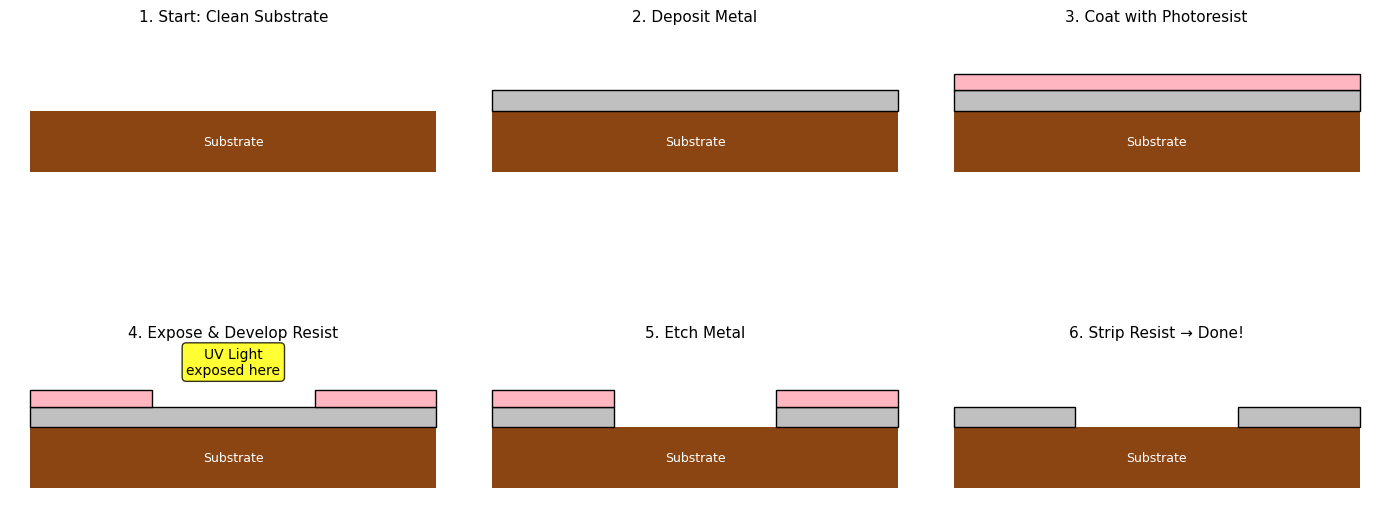

In [10]:
# Visualizing the basic fabrication cycle
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

def draw_cross_section(ax, title, substrate=True, metal=None, oxide=None, resist=None, annotation=None):
    """Draw a simplified cross-section."""
    if substrate:
        ax.add_patch(patches.Rectangle((0, 0), 10, 1.5, facecolor='#8B4513'))
        ax.text(5, 0.75, 'Substrate', ha='center', va='center', color='white', fontsize=9)
    if oxide:
        ax.add_patch(patches.Rectangle((0, 1.5), 10, oxide, facecolor='#ADD8E6'))
    if metal == 'full':
        ax.add_patch(patches.Rectangle((0, 1.5), 10, 0.5, facecolor='#C0C0C0', edgecolor='black'))
    elif metal == 'patterned':
        ax.add_patch(patches.Rectangle((0, 1.5), 3, 0.5, facecolor='#C0C0C0', edgecolor='black'))
        ax.add_patch(patches.Rectangle((7, 1.5), 3, 0.5, facecolor='#C0C0C0', edgecolor='black'))
    if resist == 'full':
        ax.add_patch(patches.Rectangle((0, 2.0), 10, 0.4, facecolor='#FFB6C1', edgecolor='black'))
    elif resist == 'patterned':
        ax.add_patch(patches.Rectangle((0, 2.0), 3, 0.4, facecolor='#FFB6C1', edgecolor='black'))
        ax.add_patch(patches.Rectangle((7, 2.0), 3, 0.4, facecolor='#FFB6C1', edgecolor='black'))
    if annotation:
        ax.annotate(annotation[0], xy=annotation[1], fontsize=10, ha='center',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(-0.2, 3.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=11)
    ax.axis('off')

draw_cross_section(axes[0], "1. Start: Clean Substrate")
draw_cross_section(axes[1], "2. Deposit Metal", metal='full')
draw_cross_section(axes[2], "3. Coat with Photoresist", metal='full', resist='full')
draw_cross_section(axes[3], "4. Expose & Develop Resist", metal='full', resist='patterned',
                  annotation=('UV Light\nexposed here', (5, 2.8)))
draw_cross_section(axes[4], "5. Etch Metal", metal='patterned', resist='patterned')
draw_cross_section(axes[5], "6. Strip Resist → Done!", metal='patterned')

plt.tight_layout()
plt.show()

### Front End vs Back End Processing

**Front End (FEOL)**
- Transistor/device formation
- Most complex and critical steps
- Defines device performance

**Back End (BEOL)**
- Metal interconnect layers
- Repeated deposit → pattern → etch cycle
- `metal → dielectric → metal → dielectric → ...`

### What's Taking So Long?

| Factor | Description |
|--------|-------------|
| **Inspection steps** | Quality checks between process steps |
| **Queues** | Waiting for tool availability |
| **Rework** | Fixing issues discovered during inspection |
| **Process monitors** | Test structures to verify process parameters |
| **Tool downtime & repairs** | Equipment maintenance |
| **Holds** | Waiting for engineering decisions |

---
<a id="8-chip-delivery--packaging"></a>
# 8. Chip Delivery & Packaging
---

## Packaging Options

### Bare Die
- **Gel packs** — Die shipped in protective gel
- **Waffle packs** — Plastic trays with individual pockets
- **Wirebonding** — You handle the packaging

### Packaged Parts
- **DIP / SIP / through-hole packages** — Easy to prototype with
- **SMT / Surface mount packages** — Production-ready
- **BGA / Flip-chip** — High pin count, high performance

## Fabrication Summary Data

Specifications you might receive with your chips:

| Measurement | What it tells you |
|-------------|-------------------|
| **Sheet resistance** | Metal and via quality |
| **Capacitance** | Dielectric thickness and quality |
| **Line/space CD** | Critical dimension measurements |
| **Defect density** | Process cleanliness |

---
<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); color: white; padding: 30px; margin: 20px -10px -10px -10px; border-radius: 15px 15px 0 0; text-align: center;">

## Summary

**Layout** → **Verification (DRC/LVS)** → **Tape Out** → **Fabrication** → **Delivery**

### Homework
1. Hand-draw an inverter layout using PDK layers (on paper or in a tool)
2. Run DRC on an example layout — identify and correct any violations
3. Sketch a block diagram for your project showing major components and data flow

</div>

---

*This notebook is designed for use with JupyterLite — runs entirely in your browser!*